# LOW AA0.5 real-time calibration tests

In this notebook, RASCIL functions are used to simulate AA0.5 data with LOW array, beam and sky models, and thermal noise is added at realistic levels. Calibration is then performed for a number of different station-based distortions to investigate how much averaging may be required to generate acceptable real-time calibration solutions. This is done for a "calibration" field, with a dominant central radio source, and a "quiet" field, with no dominant components. Fields with bright extended emission are not considered.

Note that this initial version of the notebook is using the old RASCIL data models. It will be updated with the new data models in the near future.

### Summary of initial results

After some preliminary tests outlined below, some general remarks can be made. Note that the simulations do not include beam errors, out-of-field sources, the ionosphere, etc., which can all affect the level of calibration errors. And while some sky model errors are included, the long-or-short nature of AA0.5 baselines will lead to additional errors for partially-resolved sources. We could look into using GLEAM-X data, which has the right baseline and frequency coverage, and check that RASCIL skycomponent functions use the source morphology information. Also, it is possible that, for instance, there may be a missing sqrt(2) scaling factor between sky model flux densities and the thermal noise. This notebook should be considered a rough guide until it has been more thoroughly reviewed. An approach for adding ionospheric phase fluctuations is ready to incorporate into the notebook, but there was not enough time in PI16.

##### Calibration field (3C 444)

Calibrating towards a field containing the strong radio galaxy 3C 444 resulted in phase errors less than a degree on calibration intervals relevant for AA0.5: 1 MHz solution bandwidths and 1 sec integrations. Deeper averages lead to lower phase errors, in particular when the integration was in frequency.

Including weaker sources in the calibration model also helped to reduce the phase errors, however in the case of 3C 444 reasonable calibration was also achieved with only a shallow calibration model.

##### Quiet field (MWA EoR0)

For the relatively low signal-to-noise EoR0 field, averaging in both time and frequency helped to push down the calibration errors. For the nominal calibration update rate of 10 seconds, solution bandwidths of several MHz or more led to phase errors of a few degrees or lower.

The depth of the calibration sky model did have more of a significant effect with this field. Including sources in or near the beam with flux densities below 100 mJy was seen to be useful, and going deeper than 1 Jy was required.

### Imports

In [1]:
import os
import sys
import time
import copy

t0 = time.time()

import numpy as np

import xarray as xr

from numpy import sin as sin
from numpy import cos as cos

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
import astropy.constants as consts

from rascil.data_models import PolarisationFrame
from rascil.processing_components import create_named_configuration
from rascil.processing_components import create_blockvisibility

from rascil.processing_components.calibration.operations import create_gaintable_from_blockvisibility

from rascil.processing_components.simulation.testing_support import create_low_test_image_from_gleam
from rascil.processing_components.simulation.testing_support import create_low_test_skycomponents_from_gleam

from rascil.processing_components.imaging.primary_beams import create_low_test_beam
from rascil.processing_components.imaging.dft import dft_skycomponent_visibility

from rascil.processing_components.skycomponent.operations import apply_beam_to_skycomponent
from rascil.processing_components.skycomponent.operations import filter_skycomponents_by_flux

from jones_solvers.processing_components import solve_jones

t_import = time.time() - t0

### Set up logging

In [2]:
import logging
from importlib import reload

logging.shutdown()
reload(logging)

log = logging.getLogger()
#log.setLevel(logging.DEBUG)
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)

np.set_printoptions(linewidth=-1)

### Initialise visibility data model

At this point a number of simulation parameters are set.
* *prng* is an instance of the numpy random number generator that can be fixed such that consecutive runs of the notebook give the same random numbers (i.e. the same gain deviations and noise). This can be useful when comparing different parameter settings without the complication of additional variations due to noise, etc.
* parameters *nsamples* and *sample_time* set the number of time samples and the sample interval in seconds, respectively.
* parameters *nchannels* and *channel_bandwidth* set the number of frequency channels and the channel width in Hz, respectively. The first channel is set to 100 MHz.
* parameter *field* is used to select either the quiet MWA EoR0 field or the field around dominant calibrator source 3C 444.
* parameter *flux_min* (Jy) sets the component flux cutoff for the sky model.
* parameter *flux_dft* (Jy) sets the component flux cutoff for the part of the sky model used for calibration.
* vector *subarray* is used to select which stations to include in the simulation. Note that RASCIL now has in-built AA0.5 configurations, and these the notebook will use those directly soon.

In [3]:
log.info("Init blockvisibility")

t0 = time.time()

# use a fixed seed for the RNG, or seed in the normal way?
fixed_seed = round(consts.h.value*1e34*1e8) # some constant between 0 and 2**32-1
prng = np.random.RandomState(fixed_seed)
#prng = np.random.RandomState()

nsamples = 3
sample_time = 10.0
nchannels = 10
channel_bandwidth = 1.0e6

# select the two most longitudinally separated stations in each cluster
subarray = np.array([345,346,353,354,431,433])-1
# or select a larger sub-array. Say one station from all clusters on the south arm:
# subarray = np.array([273,279,285,291,327,333,339,345,351,429,435,441,447,453,459,465])-1
# or select a random sub-array
# subarray = np.unique((prng.rand(50)*512).astype("int"))

field = "EoR0"

if field == "EoR0":

    # MWA field EoR0:
    ra0 = 0.0 * u.hourangle
    dec0 = -27.0 * u.deg

    flux_min = 0.0
    flux_dft = 0.1

elif field == "3C444":

    # 3C 444, ~ 113 Jy @ 100 MHz and ~ 88 Jy @ 130 MHz
    ra0 = (22+14/60+25.7/3600) * u.hourangle
    dec0 = -(17+1/60+36/3600) * u.deg

    flux_min = 0.0
    flux_dft = 1.0

else:
    raise Exception("unknown field "+field)

lowconfig = create_named_configuration('LOWBD2')
lon = 116.76444824 * np.pi / 180. # how can I extract these from lowconfig?
lat = -26.82472208 * np.pi / 180.

times = (np.pi / 43200.0) * np.arange(0,nsamples*sample_time, sample_time)
frequency = np.arange(100.0e6, 100.0e6+nchannels*channel_bandwidth, channel_bandwidth)
channel_bandwidth = np.array(nchannels*[channel_bandwidth])

phasecentre = SkyCoord(ra=ra0, dec=dec0, frame='icrs', equinox='J2000')

# create empty blockvis with intrumental polarisation (XX, XY, YX, YY)
modelVis = create_blockvisibility(lowconfig, times, frequency, channel_bandwidth=channel_bandwidth,
                                  phasecentre=phasecentre, sample_time=sample_time,
                                  polarisation_frame=PolarisationFrame("linear"), weight=1.0)

assert modelVis['vis'].shape[0]   == nsamples, "Shape inconsistent with specified number of times"
assert modelVis['vis'].shape[2]   == nchannels, "Shape inconsistent with specified number of channels"
assert modelVis['vis'].shape[3]   == 4, "Shape inconsistent with specified number of polarisations"
assert modelVis['vis'].shape[0:3] == modelVis["uvw_lambda"].data.shape[0:3], "vis & uvw_lambda avr inconsistent"
assert all(modelVis['polarisation'].data == ['XX', 'XY', 'YX', 'YY']), "Polarisations inconsistent with expectations"

stations = lowconfig["stations"]
nstations = stations.shape[0]
nvis = modelVis["baselines"].shape[0]

nsubarray = len(subarray)
modelVis = modelVis.where(modelVis["antenna1"].isin(subarray) * modelVis["antenna2"].isin(subarray), drop=True)
nvis = modelVis["baselines"].shape[0]

log.info("--------------------------------------------------------------------------")
log.info("Sub-array:")
log.info(" - nstations = {}".format(nsubarray))
log.info(" - nproducts = {}".format(int(nsubarray*(nsubarray+1)/2)))
log.info(" - nbaseline = {}".format(int(nsubarray*(nsubarray-1)/2)))
log.info(" - vis['vis'].shape = {}".format(modelVis['vis'].shape))
log.info(" - nvis = {}".format(nvis))
log.info("")
log.info(" - lowconfig shape = {}".format(lowconfig["xyz"].data.shape))
for stn in subarray:
    log.info("      station {:3d} XY = {:+8.1f}, {:+8.1f}".format(
             stn,lowconfig["xyz"].data[stn,0],lowconfig["xyz"].data[stn,1]))
log.info("--------------------------------------------------------------------------")

t_initvis = time.time() - t0

log.info("Done")

Init blockvisibility
--------------------------------------------------------------------------
Sub-array:
 - nstations = 6
 - nproducts = 21
 - nbaseline = 15
 - vis['vis'].shape = (3, 21, 10, 4)
 - nvis = 21

 - lowconfig shape = (512, 3)
      station 344 XY =  -6102.0,  -8240.1
      station 345 XY =  -6169.4,  -8330.1
      station 352 XY =  -3876.7, -11388.6
      station 353 XY =  -3928.8, -11291.8
      station 430 XY = -10647.5,  -9249.3
      station 432 XY = -10649.9,  -9141.0
--------------------------------------------------------------------------
Done


### Generate the sky model and update the visibilities

A few more parameters are set here. The initial plan was to use an image-based sky model with separate DFT components only for the stronger radio sources. As such, the extent of the sky model is set with image parameters *npixel* and *cellsize*. These are 1D parameters for the width and height of the image in pixels, and with width and height of each pixel in radians.

In [4]:
log.info("Gen sky model and updating vis")

t0 = time.time()

# get components in an image that is about 8.5 degrees across
npixel=512
cellsize = 1.0/60 * np.pi/180.
radius = cellsize*(npixel/2-1)

# there is a dec filtering bug in create_low_test_skycomponents_from_gleam, so double this for now:
radius *= 2

# define a function to cut the sky model back to the actual radius later on
def filter_skycomponents_by_sep(sc, phasecentre, radius=np.inf):
    """Filter sky components by max separation from some point

    :param sc: List of Skycomponents
    :param phasecentre: central location
    :param radius: Maximum separation in radians
    :return:
    """
    radius_deg = radius * 180.0 / np.pi
    newcomps = list()
    for comp in sc:
        if comp.direction.separation(phasecentre).value < radius_deg: newcomps.append(comp)
    return newcomps

print("search radius is {} deg or 00h{:04.1}m".format(radius*180/np.pi,radius*12/np.pi*60))
print("search radius/cos(dec) 00h{:04.1}m".format(radius/cos(-27*np.pi/180)*12/np.pi))

# I would generate a Stokes I model and then convert to instrument polarisation_frame using 
# convert_blockvisibility_stokesI_to_polframe, but the sub-arraying above is causing some data variables to change
# shape, which in turn is causing convert_blockvisibility_stokesI_to_polframe to crash. So do everything with linear
# polarisation_frame from the start -- which incorrectly just puts Stokes I in XX, and then copy XX to YY. I'm not
# particularly worried about cross terms for these tests.
# Will be removing the sub-ararying step soon, so don't worry further about this.

sm_cmp = create_low_test_skycomponents_from_gleam(
             polarisation_frame=PolarisationFrame("linear"),
             frequency=frequency, phasecentre=phasecentre,
             flux_limit=flux_min, radius=radius)

# cut the sky model back to the actual radius (was extended to avoid a dec cropping error)
radius /= 2
sm_cmp = filter_skycomponents_by_sep(sm_cmp, phasecentre=phasecentre, radius=radius)

# extract main components for the calibration sky model
sm_cmp_main = filter_skycomponents_by_flux(sm_cmp, flux_min=flux_dft)

# extract weaker sources to add to the full sky model
# planned to use an image-based model for this, but didn't have time to get it working
# later try: create_low_test_image_from_gleam -> create_griddata_from_image -> degrid_blockvisibility_from_griddata
sm_cmp_weak = filter_skycomponents_by_flux(sm_cmp, flux_min=flux_min, flux_max=flux_dft)

# do need a grid for the beam generation though, but don't bother adding components
wm_img = create_low_test_image_from_gleam(
             polarisation_frame=PolarisationFrame("linear"),
             frequency=frequency, phasecentre=phasecentre,
             flux_limit=np.inf, radius=0,
             npixel=npixel, cellsize=cellsize,
             flux_min=np.inf,
             insert_method='Nearest', applybeam=False)

# create the beam and weight the sky model components
bm = create_low_test_beam(model=wm_img)
wm_cmp_main = apply_beam_to_skycomponent(sm_cmp_main, bm, phasecentre=phasecentre)
wm_cmp_weak = apply_beam_to_skycomponent(sm_cmp_weak, bm, phasecentre=phasecentre)

# log a little bit of sky model info
Ndft = len(wm_cmp_main)
sm_flux = np.zeros(Ndft)
wm_flux = np.zeros(Ndft)
for k in range(0,Ndft):
    sm_flux[k] = sm_cmp_main[k].flux[0,0]
    wm_flux[k] = wm_cmp_main[k].flux[0,0]
log.info("Using {} secondary components < {} Jy and {} main components".format(len(wm_cmp_weak),flux_dft,len(wm_cmp_main)))
log.info(" - maximum catalogue flux is {:.1f} Jy".format(max(sm_flux)))
log.info(" - maximum beam-weighted flux is {:.1f} Jy".format(max(wm_flux)))

# DFT the two sky model populations
log.info("Doing DFTs")
mainVis = modelVis.copy(deep=True)
mainVis = dft_skycomponent_visibility(mainVis, wm_cmp_main)
weakVis = modelVis.copy(deep=True)
weakVis = dft_skycomponent_visibility(weakVis, wm_cmp_weak)

# Only XX is non-zero (presumably Stokes I), so copy XX to YY
#  - note that the noise levels below could assume I=XX+YY or I=XX/2+YY/2
#  - need to clarify
mainVis['vis'].data[:,:,:,3] = mainVis['vis'].data[:,:,:,0]
weakVis['vis'].data[:,:,:,3] = weakVis['vis'].data[:,:,:,0]

# use these sky model visibilities to set the ideal model and "observed" visibilities.
modelVis = mainVis.copy(deep=True)
noiselessVis = mainVis.copy(deep=True)
noiselessVis['vis'].data += weakVis['vis'].data

t_fillvis = time.time() - t0

log.info("Done")

Gen sky model and updating vis
search radius is 8.5 deg or 00h3e+01m
search radius/cos(dec) 00h00.6m
Using 245 secondary components < 0.1 Jy and 734 main components
 - maximum catalogue flux is 15.0 Jy
 - maximum beam-weighted flux is 4.8 Jy
Doing DFTs
Done


### Plot the sky model

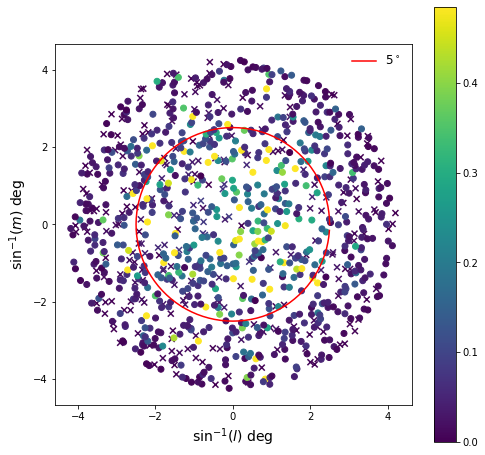

In [5]:
plt.figure(figsize=(8,8), facecolor='w', edgecolor='k')
plt.subplot(111, aspect="equal")

cdec0 = np.cos(dec0);
sdec0 = np.sin(dec0);

cmax = np.amax(wm_flux)/10.

# plot the weaker components that didn't make the calibration sky model using x markers
Ncomp = len(wm_cmp_weak)
flux = np.zeros(Ncomp)
l = np.zeros(Ncomp)
m = np.zeros(Ncomp)
k = 0
for comp in wm_cmp_weak:
    cdec = np.cos(comp.direction.dec)
    sdec = np.sin(comp.direction.dec)
    cdra = np.cos(comp.direction.ra - ra0)
    sdra = np.sin(comp.direction.ra - ra0)
    l[k] = cdec*sdra;
    m[k] = sdec*cdec0 - cdec*sdec0*cdra
    flux[k] = comp.flux[0,0]
    k += 1
plt.scatter( l*180/np.pi, m*180/np.pi, c=flux, vmin=0, vmax=cmax, marker='x' )

# plot the main calibration sky model components
Ncomp = len(wm_cmp_main)
flux = np.zeros(Ncomp)
l = np.zeros(Ncomp)
m = np.zeros(Ncomp)
k = 0
for comp in wm_cmp_main:
    cdec = np.cos(comp.direction.dec)
    sdec = np.sin(comp.direction.dec)
    cdra = np.cos(comp.direction.ra - ra0)
    sdra = np.sin(comp.direction.ra - ra0)
    l[k] = cdec*sdra;
    m[k] = sdec*cdec0 - cdec*sdec0*cdra
    flux[k] = comp.flux[0,0]
    k += 1
plt.scatter( l*180/np.pi, m*180/np.pi, c=flux, vmin=0, vmax=cmax )

phi = np.arange(0,2*np.pi,np.pi/50.)
r = 2.5
plt.plot(r*cos(phi),r*sin(phi), 'r', label=r"$5^\circ$")
plt.xlabel("sin$^{-1}(l)$ deg", fontsize=14)
plt.ylabel("sin$^{-1}(m)$ deg", fontsize=14)

plt.legend(fontsize=12, frameon=False)
plt.colorbar()

### Create and apply a gain table with amplitude and phase errors

Here we create and apply some direction-independent calibration effects. In this example they are not only constant across the sky model, but also over all of the time and frequency samples. They include gain and phase variations that should be calibratable, given an adequate signal-to-noise ratio, as well as polarised effects that it will not be possible to contrain, given the unpolarised sky model.

In [6]:
log.info("Applying calibration factors and noise")

t0 = time.time()

# generate a gaintable with a single timeslice (is in sec, so should be > 43200 for a 12 hr observation)
gt_true = create_gaintable_from_blockvisibility(modelVis, timeslice=1e6, jones_type="G")
gt_fit  = create_gaintable_from_blockvisibility(modelVis, timeslice=1e6, jones_type="G")

# set up references to the data
Jt = gt_true["gain"].data
Jm = gt_fit["gain"].data

# only set gains for stations that are in the subarray
for idx in range(0,nsubarray):

    stn = subarray[idx]

    # generate the starting model station gain error matrices. Unit gains with no leakage.
    Jm[0,stn,0,:,:] = np.eye(2, dtype=complex)

    # generate the true station gain error matrices
    #  - unit gains plus a systematic XY phase shift plus some random distortions for the gain terms
    Gsigma = 0.1
    gX = np.exp(-0.0j) + Gsigma * ( prng.randn() + 1j*prng.randn() )
    gY = np.exp(+0.1j) + Gsigma * ( prng.randn() + 1j*prng.randn() )
    #  - a systematic leakage plus some random distortions for the leakage terms
    Dsigma = 0.01
    dXY = +0.05 + Dsigma * ( prng.randn() + 1j*prng.randn() )
    dYX = +0.05 + Dsigma * ( prng.randn() + 1j*prng.randn() )
    Jt[0,stn,0,:,:] = np.array([[gX, gX*dXY], [-gY*dYX, gY]])

# Apply calibration factors

# set up references to the data
stn1 = modelVis["antenna1"].data
stn2 = modelVis["antenna2"].data

for t in range(0,nsamples):
    for f in range(0,nchannels):

        # set up references to the data
        modelTmp     = modelVis['vis'].data[t,:,f,:]
        noiselessTmp = noiselessVis['vis'].data[t,:,f,:]

        for k in range(0,nvis):

            vis_in = np.reshape(modelTmp[k,:],(2,2))
            vis_out = Jm[0,stn1[k],0] @ vis_in @ Jm[0,stn2[k],0].conj().T
            modelTmp[k,:] = np.reshape(np.array(vis_out),(4))

            vis_in = np.reshape(noiselessTmp[k,:],(2,2))
            vis_out = Jt[0,stn1[k],0] @ vis_in @ Jt[0,stn2[k],0].conj().T
            noiselessTmp[k,:] = np.reshape(np.array(vis_out),(4))

# Add independent Gaussian noise to each visibility sample

# first generate the expected System Equivalent Flux Density
#  - see Sokolowski et al. 2022, PASA 39
#  - from skalowsensitivitybackup-env.eba-daehsrjt.ap-southeast-2.elasticbeanstalk.com/sensitivity_radec_vs_freq
#     - AAVS2_sensitivity_ra0.00deg_dec_-27.00deg_0.00hours.txt
#  - this is specifically for an AAVS2-like station pointing in the EoR0 direction.
#  - for more general solution, the python calculator should be installed and used.

sim_freq = np.array([ 99.8400,108.8000,119.0400,129.2800,139.5200,149.7600,154.8800,\
                     160.0000,168.9600,179.2000,185.6000,189.4400,199.6800])*1e6
sim_SEFDx = np.array([2371.964004,2155.226369,2025.520665,1914.953382,1827.958458,1818.613829,1872.251517,\
                      1940.699453,2012.247193,2120.719450,2123.762506,2092.097418,2047.851280])
sim_SEFDy = np.array([2373.570152,2162.044465,2100.491293,2052.820744,1958.236742,1998.655397,1977.974041,\
                      2078.091533,2257.589304,2390.946732,2376.884877,2347.302348,2236.785787])
SEFD_fit = interp1d(sim_freq, sim_SEFDx, kind='cubic')

SEFD = SEFD_fit(frequency)
sigma = SEFD / np.sqrt(2.*channel_bandwidth*sample_time)
log.info("Noise estimate:")
log.info(" - SEFD range = {:6.1f} - {:6.1f} Jy".format(np.min(SEFD),np.max(SEFD)))
log.info(" - sigma range = {:4.2f} - {:4.2f} Jy".format(np.min(sigma),np.max(sigma)))

observedVis = noiselessVis.copy(deep=True)

shape = observedVis['vis'].shape
assert len(shape) == 4, "require 4 dimensions for blockvisibilty"
assert shape[0] == nsamples, "unexpected time dimension"
assert shape[2] == nchannels, "unexpected frequency dimension"

for f in range(0,nchannels):
    observedVis['vis'].data[:,:,f,:] += sigma[f] * ( prng.randn(shape[0],shape[1],shape[3]) + 
                                                     prng.randn(shape[0],shape[1],shape[3]) * 1j )
    if sigma[f] > 0:
        modelVis['weight'].data[:,:,f,:] *= 1.0 / (sigma[f] * sigma[f])
        observedVis['weight'].data[:,:,f,:] *= 1.0 / (sigma[f] * sigma[f])

t_updatevis = time.time() - t0

log.info("Done")

Applying calibration factors and noise
Noise estimate:
 - SEFD range = 2151.9 - 2366.7 Jy
 - sigma range = 0.48 - 0.53 Jy
Done


### Solve for the gain factors

The Jones solvers package contains two algorithms with a number of runtime options. Here they will both be run with the default settings.

In [7]:
log.info("Solving calibration")

log.info("Running algorithm 1 with defaults")
gt1 = gt_fit.copy(deep=True)
modelVis1 = modelVis.copy(deep=True)
t0 = time.time()
chisq1 = solve_jones(observedVis, modelVis1, gt1, testvis=noiselessVis, algorithm=1, niter=50, tol=1e-6)
t_solving1 = time.time() - t0

log.info("Running algorithm 2 with defaults")
gt2 = gt_fit.copy(deep=True)
modelVis2 = modelVis.copy(deep=True)
t0 = time.time()
chisq2 = solve_jones(observedVis, modelVis2, gt2, testvis=noiselessVis, algorithm=2)
t_solving2 = time.time() - t0

log.info("Done")

Solving calibration
Running algorithm 1 with defaults
Running algorithm 2 with defaults
Done


### Plot some results

Below are two sets of plots.

The first eight panels show the real and imaginary part of the four Jones matrix elements, each as a function of the AA0.5 stations. True and fitted data are shown in different colours. While the general trend of the fitted data matches the true data, there are some offsets.

The second set of eight panels shows the fitted matrices after multiplying by the inverse of the true Jones matrices. Ideally this will be a real identity matrix plus some noise for each station, but, as mentioned above, there are polarisation effects that cannot be contrained with the unpolarised sky model. The systematic leakage term can be seen as offsets in the real cross terms, while the systematic XY-phase can be seen in the imaginary part of the Y diagonal term.

For the purposes of real-time calibration, the important thing is that the diagonal terms have unit amplitude and stable phase across the stations.

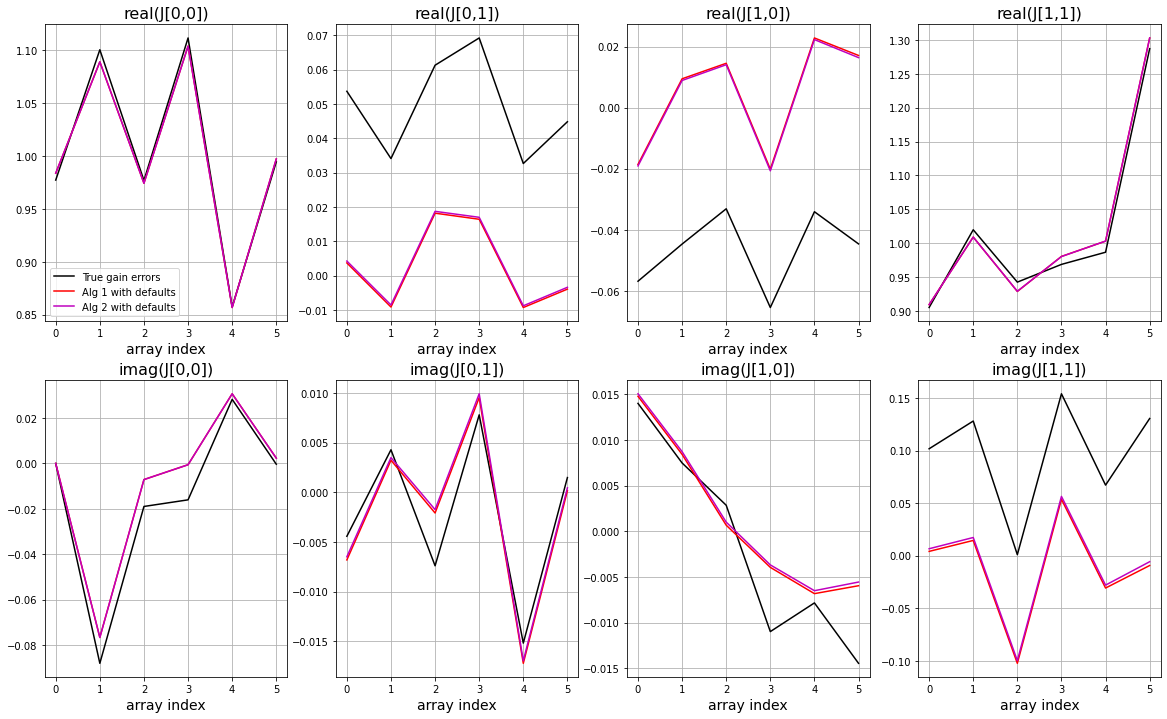

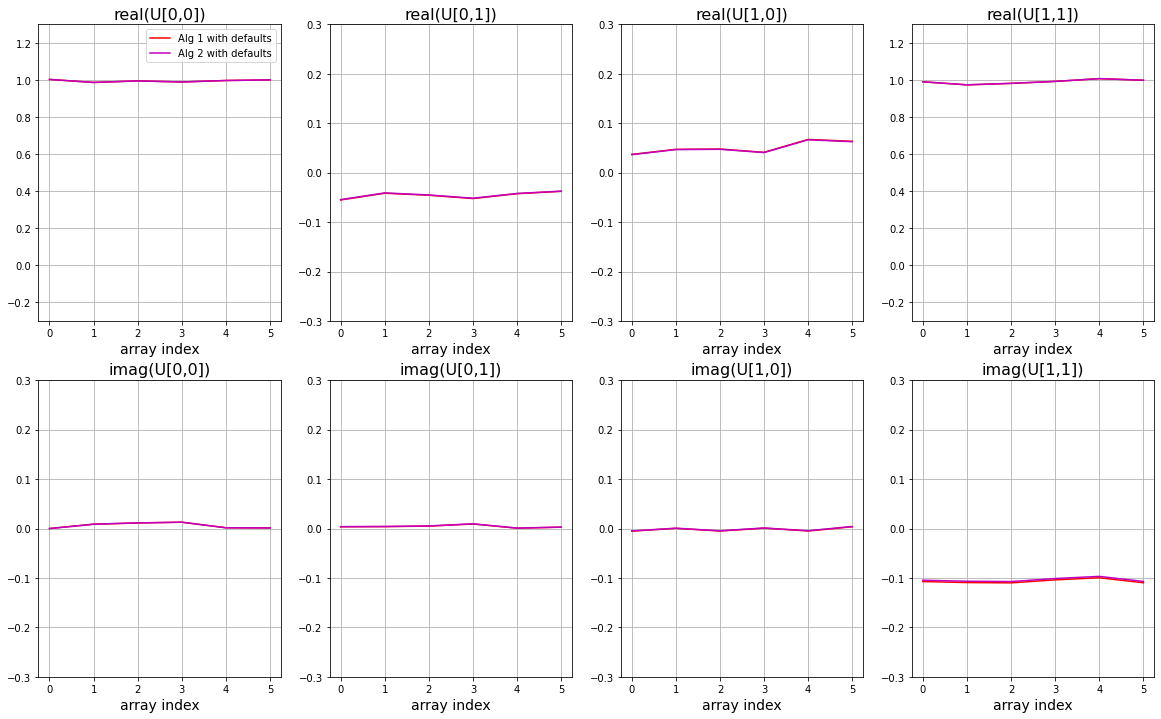

In [8]:
# copy gain data for the subarray
Jt  = gt_true["gain"].data[0,subarray,0,:,:]
J1  = gt1["gain"].data[0,subarray,0,:,:]
J2  = gt2["gain"].data[0,subarray,0,:,:]

# --- #

plt.figure("Jones matrix elements", figsize=(20,12), facecolor='w', edgecolor='k')
ax241 = plt.subplot(241); ax241.set_title("real(J[0,0])", fontsize=16)
ax242 = plt.subplot(242); ax242.set_title("real(J[0,1])", fontsize=16)
ax243 = plt.subplot(243); ax243.set_title("real(J[1,0])", fontsize=16)
ax244 = plt.subplot(244); ax244.set_title("real(J[1,1])", fontsize=16)
ax245 = plt.subplot(245); ax245.set_title("imag(J[0,0])", fontsize=16)
ax246 = plt.subplot(246); ax246.set_title("imag(J[0,1])", fontsize=16)
ax247 = plt.subplot(247); ax247.set_title("imag(J[1,0])", fontsize=16)
ax248 = plt.subplot(248); ax248.set_title("imag(J[1,1])", fontsize=16)

ax241.set_xlabel("array index", fontsize=14); ax241.grid()
ax242.set_xlabel("array index", fontsize=14); ax242.grid()
ax243.set_xlabel("array index", fontsize=14); ax243.grid()
ax244.set_xlabel("array index", fontsize=14); ax244.grid()
ax245.set_xlabel("array index", fontsize=14); ax245.grid()
ax246.set_xlabel("array index", fontsize=14); ax246.grid()
ax247.set_xlabel("array index", fontsize=14); ax247.grid()
ax248.set_xlabel("array index", fontsize=14); ax248.grid()

def plot_gain(J, col, label=""):
    #log.info(label)
    pref = np.exp(-1j*np.angle(J[0][0,0]))
    Jref = np.zeros((nsubarray,2,2),"complex")
    for stn in range(nsubarray):
        Jref[stn] = J[stn] * pref
    ax241.plot(np.real(Jref[:,0,0]),col,label=label)
    ax242.plot(np.real(Jref[:,0,1]),col)
    ax243.plot(np.real(Jref[:,1,0]),col)
    ax244.plot(np.real(Jref[:,1,1]),col)
    ax245.plot(np.imag(Jref[:,0,0]),col)
    ax246.plot(np.imag(Jref[:,0,1]),col)
    ax247.plot(np.imag(Jref[:,1,0]),col)
    ax248.plot(np.imag(Jref[:,1,1]),col)

plot_gain(Jt,'k-',"True gain errors")
plot_gain(J1,'r-',"Alg 1 with defaults")
plot_gain(J2,'m-',"Alg 2 with defaults")
ax241.legend(fontsize=10)

# --- #

plt.figure("Ambiguity matrix elements", figsize=(20,12), facecolor='w', edgecolor='k')
ax241 = plt.subplot(241); ax241.set_title("real(U[0,0])", fontsize=16)
ax242 = plt.subplot(242); ax242.set_title("real(U[0,1])", fontsize=16)
ax243 = plt.subplot(243); ax243.set_title("real(U[1,0])", fontsize=16)
ax244 = plt.subplot(244); ax244.set_title("real(U[1,1])", fontsize=16)
ax245 = plt.subplot(245); ax245.set_title("imag(U[0,0])", fontsize=16)
ax246 = plt.subplot(246); ax246.set_title("imag(U[0,1])", fontsize=16)
ax247 = plt.subplot(247); ax247.set_title("imag(U[1,0])", fontsize=16)
ax248 = plt.subplot(248); ax248.set_title("imag(U[1,1])", fontsize=16)

ax241.set_xlabel("array index", fontsize=14); ax241.grid()
ax242.set_xlabel("array index", fontsize=14); ax242.grid()
ax243.set_xlabel("array index", fontsize=14); ax243.grid()
ax244.set_xlabel("array index", fontsize=14); ax244.grid()
ax245.set_xlabel("array index", fontsize=14); ax245.grid()
ax246.set_xlabel("array index", fontsize=14); ax246.grid()
ax247.set_xlabel("array index", fontsize=14); ax247.grid()
ax248.set_xlabel("array index", fontsize=14); ax248.grid()

def plot_ambiguity(J, col, label=""):
    # log.info(label)
    U0 = J[0] @ np.linalg.inv(Jt[0])
    pref = np.exp(-1j*np.angle(U0[0,0]))
    U = np.zeros((nsubarray,2,2),"complex")
    for stn in range(nsubarray):
        U[stn] = J[stn] @ np.linalg.inv(Jt[stn]) * pref
    ax241.plot(np.real(U[:,0,0]),col,label=label)
    ax242.plot(np.real(U[:,0,1]),col)
    ax243.plot(np.real(U[:,1,0]),col)
    ax244.plot(np.real(U[:,1,1]),col)
    ax245.plot(np.imag(U[:,0,0]),col)
    ax246.plot(np.imag(U[:,0,1]),col)
    ax247.plot(np.imag(U[:,1,0]),col)
    ax248.plot(np.imag(U[:,1,1]),col)

ax241.set_ylim((-0.3,+1.3))
ax242.set_ylim((-0.3,+0.3))
ax243.set_ylim((-0.3,+0.3))
ax244.set_ylim((-0.3,+1.3))
ax245.set_ylim((-0.3,+0.3))
ax246.set_ylim((-0.3,+0.3))
ax247.set_ylim((-0.3,+0.3))
ax248.set_ylim((-0.3,+0.3))

plot_ambiguity(J1,'r-',"Alg 1 with defaults")
plot_ambiguity(J2,'m-',"Alg 2 with defaults")
ax241.legend(fontsize=10)

Also plot the error as a function of solver iteration.

g_sigma = 2.96e-03


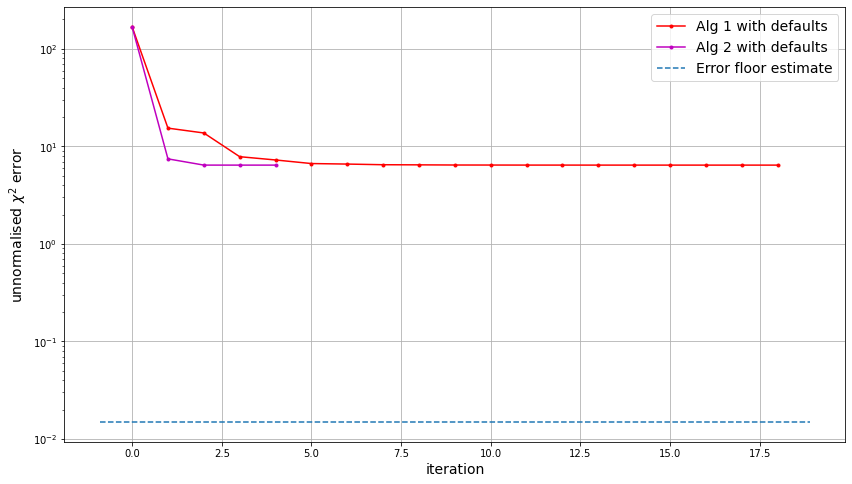

In [9]:
plt.figure(figsize=(14,8), facecolor='w', edgecolor='k')

# back of the envelope estimate of the error RMS level
#  - really should be doing the frequency averaging properly here
Mij = modelVis.sel({"antenna1": subarray[0]})['vis'].data[0,1::,0,0]
# could use the mean of all vis and multiply by nstn-1. Careful of autos though
g_sigma = np.sqrt( sigma**2 / np.sum(np.abs(Mij)**2) / float(nsamples*nchannels) )
v_sigma = 2 * np.sqrt( np.mean(np.abs(Mij)**2) * g_sigma**2 )
log.info("g_sigma = {:.2e}".format(g_sigma[0]))

ax1 = plt.subplot(111)
ax1.set_yscale('log')
plt.plot( chisq1, '.r-', label="Alg 1 with defaults" )
plt.plot( chisq2, '.m-', label="Alg 2 with defaults" )
if np.any(sigma>0): plt.plot( ax1.get_xlim(), 2*v_sigma[0]**2*np.ones(2), '--', label="Error floor estimate" )
plt.xlabel("iteration", fontsize=14)
plt.ylabel(r"unnormalised $\chi^2$ error", fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.grid()

### Runtimes

While the first algorithm took more iterations to converge than the second algorithm, each iteration was faster and the overall time was less. While either if fine for AA0.5 RCAL, the scaling becomes more relevant as the number of stations is increased. Note, however, that the slower algorithm can in some situations be more accurate.

In [10]:
fstr = ' - {:<35} {:6.1f} sec'
log.info("")
log.info("Timing:")
log.info(fstr.format("package imports", t_import))
log.info(fstr.format("init blockvis", t_initvis))
log.info(fstr.format("predict blockvis", t_fillvis))
log.info(fstr.format("apply corruptions", t_updatevis))
tstr = fstr.format("Alg 1 with defaults", t_solving1)
if len(chisq1) > 0: tstr+=" for {} iterations".format(len(chisq1))
log.info(tstr)
tstr = fstr.format("Alg 2 with default lsmr", t_solving2)
if len(chisq2) > 0: tstr+=" for {} iterations".format(len(chisq2))
log.info(tstr)
log.info("")


Timing:
 - package imports                        4.7 sec
 - init blockvis                          3.7 sec
 - predict blockvis                      15.4 sec
 - apply corruptions                      0.1 sec
 - Alg 1 with defaults                    0.2 sec for 19 iterations
 - Alg 2 with default lsmr                0.9 sec for 5 iterations



### Time and frequency averaging

We now consider how averaging affects the quality of solutions for LOW AA0.5 real-time calibration. For this we consider band-pass calibration with differernt solution intervals and widths, and measure the standard deviation of the phase errors.

First we need to regenerate the data with more spectral channels

In [11]:
# reset the random seed if necessary
prng = np.random.RandomState(fixed_seed)

# reset the samples
nsamples = 1
sample_time = 10.0
nchannels = 128 # make this a power of 2 for the averaging
channel_bandwidth = 0.5e6

# reset the field if necessary 
field = "3C444"

if field == "EoR0":

    # MWA field EoR0:
    ra0 = 0.0 * u.hourangle
    dec0 = -27.0 * u.deg

    flux_min = 0.0
    flux_dft = 0.1

elif field == "3C444":

    # 3C 444, J2000 22:14:25.7, -17:01:36, 137 Jy @ 408 MHz:
    ra0 = (22+14/60+25.7/3600) * u.hourangle
    dec0 = -(17+ 1/60+36/3600) * u.deg

    flux_min = 0.0
    flux_dft = 1.0

else:
    raise Exception("unknown field "+field)

# reset a number of other parameters and arrays

times = (np.pi / 43200.0) * np.arange(0,nsamples*sample_time, sample_time)
frequency = np.arange(100.0e6, 100.0e6+nchannels*channel_bandwidth, channel_bandwidth)
channel_bandwidth = np.array(nchannels*[channel_bandwidth])

phasecentre = SkyCoord(ra=ra0, dec=dec0, frame='icrs', equinox='J2000')

modelVis = create_blockvisibility(lowconfig, times, frequency, channel_bandwidth=channel_bandwidth,
                                  phasecentre=phasecentre, sample_time=sample_time,
                                  polarisation_frame=PolarisationFrame("linear"), weight=1.0)

assert modelVis['vis'].shape[0]   == nsamples, "Shape inconsistent with specified number of times"
assert modelVis['vis'].shape[2]   == nchannels, "Shape inconsistent with specified number of channels"
assert modelVis['vis'].shape[3]   == 4, "Shape inconsistent with specified number of polarisations"
assert modelVis['vis'].shape[0:3] == modelVis["uvw_lambda"].data.shape[0:3], "vis & uvw_lambda avr inconsistent"
assert all(modelVis['polarisation'].data == ['XX', 'XY', 'YX', 'YY']), "Polarisations inconsistent with expectations"

modelVis = modelVis.where(modelVis["antenna1"].isin(subarray) * modelVis["antenna2"].isin(subarray), drop=True)
nvis = modelVis["baselines"].shape[0]

log.info("Regenerating sky model and updating vis")

radius = cellsize*(npixel/2-1)
radius *= 2

sm_cmp = create_low_test_skycomponents_from_gleam(
             polarisation_frame=PolarisationFrame("linear"),
             frequency=frequency, phasecentre=phasecentre,
             flux_limit=flux_min, radius=radius)

radius /= 2
sm_cmp = filter_skycomponents_by_sep(sm_cmp, phasecentre=phasecentre, radius=radius)

sm_cmp_main = filter_skycomponents_by_flux(sm_cmp, flux_min=flux_dft)
sm_cmp_weak = filter_skycomponents_by_flux(sm_cmp, flux_min=flux_min, flux_max=flux_dft)

wm_img = create_low_test_image_from_gleam(
             polarisation_frame=PolarisationFrame("linear"),
             frequency=frequency, phasecentre=phasecentre,
             flux_limit=np.inf, radius=0,
             npixel=npixel, cellsize=cellsize,
             flux_min=np.inf,
             insert_method='Nearest', applybeam=False)

bm = create_low_test_beam(model=wm_img)
wm_cmp_main = apply_beam_to_skycomponent(sm_cmp_main, bm, phasecentre=phasecentre)
wm_cmp_weak = apply_beam_to_skycomponent(sm_cmp_weak, bm, phasecentre=phasecentre)

Ndft = len(wm_cmp_main)
sm_flux = np.zeros(Ndft)
wm_flux = np.zeros(Ndft)
for k in range(0,Ndft):
    sm_flux[k] = sm_cmp_main[k].flux[0,0]
    wm_flux[k] = wm_cmp_main[k].flux[0,0]

log.info("Using {} secondary sources < {} Jy and {} main sources".format(len(wm_cmp_weak),flux_dft,len(wm_cmp_main)))
log.info(" - maximum catalogue flux is {:.1f} Jy".format(max(sm_flux)))
log.info(" - maximum beam-weighted flux is {:.1f} Jy".format(max(wm_flux)))

log.info("Doing DFTs")
mainVis = modelVis.copy(deep=True)
mainVis = dft_skycomponent_visibility(mainVis, wm_cmp_main)
weakVis = modelVis.copy(deep=True)
weakVis = dft_skycomponent_visibility(weakVis, wm_cmp_weak)

# Put in XX, so copy XX to YY
mainVis['vis'].data[:,:,:,3] = mainVis['vis'].data[:,:,:,0]
weakVis['vis'].data[:,:,:,3] = weakVis['vis'].data[:,:,:,0]

# use these sky model visibilities to set the ideal model and "observed" visibilities.
modelVis = mainVis.copy(deep=True)
noiselessVis = mainVis.copy(deep=True)
noiselessVis['vis'].data += weakVis['vis'].data

log.info("Done")

Regenerating sky model and updating vis
Using 918 secondary sources < 1.0 Jy and 70 main sources
 - maximum catalogue flux is 112.4 Jy
 - maximum beam-weighted flux is 112.4 Jy
Doing DFTs
Done


### Recreate and reapply the gain table

In [12]:
log.info("Applying calibration factors and noise")

t0 = time.time()

# This time change the jones_type to "B"
gt_true = create_gaintable_from_blockvisibility(modelVis, timeslice=1e6, jones_type="B")
gt_fit  = create_gaintable_from_blockvisibility(modelVis, timeslice=1e6, jones_type="B")

# set up references to the data
Jt = gt_true["gain"].data
Jm = gt_fit["gain"].data

# only both setting gains for stations that are in the subarray
for idx in range(0,nsubarray):

    stn = subarray[idx]

    # generate the starting model station gain error matrices. Unit gains with no leakage.
    Jm[0,stn,:,0,0] = 1
    Jm[0,stn,:,1,1] = Jm[0,stn,:,0,0]

    # add a delay for the true station gain error matrices
    Dsigma = 0.1 # e.g. cable-length correction error in metres
    Jt[0,stn,:,0,0] = np.exp(-1j*2*np.pi * Dsigma * frequency/consts.c.value * prng.randn())
    # or se t spectrally-flat phase shifts if averaging errors become apparent
    # Jt[0,stn,:,0,0] = np.exp(-1j*2*np.pi * Dsigma * frequency[0]/consts.c.value * prng.randn())
    Jt[0,stn,:,1,1] = Jt[0,stn,:,0,0]

# Apply calibration factors

stn1 = modelVis["antenna1"].data
stn2 = modelVis["antenna2"].data

for t in range(0,nsamples):
    for f in range(0,nchannels):

        # set up references to the data
        modelTmp     = modelVis['vis'].data[t,:,f,:]
        noiselessTmp = noiselessVis['vis'].data[t,:,f,:]

        for k in range(0,nvis):

            vis_in = np.reshape(modelTmp[k,:],(2,2))
            vis_out = Jm[0,stn1[k],f] @ vis_in @ Jm[0,stn2[k],f].conj().T
            modelTmp[k,:] = np.reshape(np.array(vis_out),(4))

            vis_in = np.reshape(noiselessTmp[k,:],(2,2))
            vis_out = Jt[0,stn1[k],f] @ vis_in @ Jt[0,stn2[k],f].conj().T
            noiselessTmp[k,:] = np.reshape(np.array(vis_out),(4))

# Add noise to a visibility

SEFD = SEFD_fit(frequency)
sigma = SEFD / np.sqrt(2.*channel_bandwidth*sample_time)

observedVis = noiselessVis.copy(deep=True)
shape = observedVis['vis'].shape
assert len(shape) == 4, "require 4 dimensions for blockvisibilty"
assert shape[0] == nsamples, "unexpected time dimension"
assert shape[2] == nchannels, "unexpected frequency dimension"
for f in range(0,nchannels):
    observedVis['vis'].data[:,:,f,:] += sigma[f] * ( prng.randn(shape[0],shape[1],shape[3]) + 
                                                     prng.randn(shape[0],shape[1],shape[3]) * 1j )
    if sigma[f] > 0:
        modelVis['weight'].data[:,:,f,:] *= 1.0 / (sigma[f] * sigma[f])
        observedVis['weight'].data[:,:,f,:] *= 1.0 / (sigma[f] * sigma[f])

log.info("Done")

Applying calibration factors and noise
Done


### Solve for the gain factors

Loop over the calibration several times, each time changing the width of the frequency averaging used in each bandpass solution.

Solving calibration
10sec x 0.5MHz std: re=9.8e-03,im=1.1e-02 & abs=9.7e-03, $\phi$0.62 deg
10sec x 1.0MHz std: re=8.8e-03,im=9.4e-03 & abs=8.6e-03, $\phi$0.54 deg
10sec x 2.0MHz std: re=6.9e-03,im=7.9e-03 & abs=6.9e-03, $\phi$0.45 deg
10sec x 4.0MHz std: re=5.9e-03,im=6.6e-03 & abs=5.9e-03, $\phi$0.38 deg
10sec x 8.0MHz std: re=5.4e-03,im=5.6e-03 & abs=5.3e-03, $\phi$0.32 deg
10sec x 16.0MHz std: re=5.0e-03,im=4.5e-03 & abs=4.9e-03, $\phi$0.26 deg
10sec x 32.0MHz std: re=4.2e-03,im=3.2e-03 & abs=4.0e-03, $\phi$0.19 deg


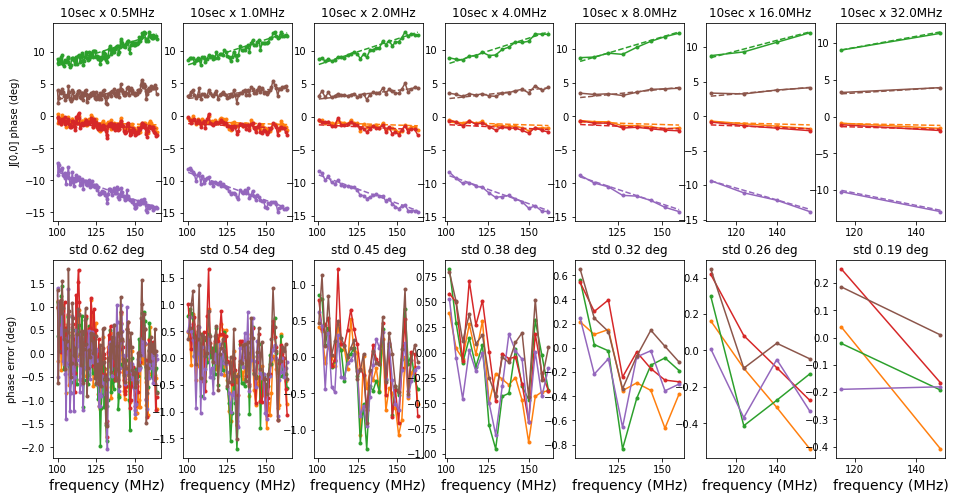

In [13]:
log.info("Solving calibration")

# assume that nchannels is a power of 2 and just double the solution bandwidth for each test
nrestests = int(np.log2(nchannels))

std_real  = np.zeros(nrestests)
std_imag  = np.zeros(nrestests)
std_abs   = np.zeros(nrestests)
std_phase = np.zeros(nrestests)

# calculate weights for the weighted average of true gains
snrwgt = np.zeros(nchannels)
for f in range(0,nchannels):
    x = modelVis['vis'].data[:,:,f,0]
    snrwgt[f] = np.mean(np.real(x*np.conj(x))) / sigma[f]**2 * nsamples

fig = plt.figure(figsize=(16,8), facecolor='w', edgecolor='k')

for test in range(0,nrestests):

    nave = 2**test
    nsubbands = nchannels // nave
    assert nsubbands * nave == nchannels, "spec channels do not divide evenly for test"

    # just point to the first nsubbands channels of the gain table
    gt1 = gt_fit.copy(deep=True)
    J1  = gt1["gain"].data[:,:,0:nsubbands,:,:]

    # also init an array for the average of Jt to the current resolution
    Jshape = list(Jt.shape)
    Jshape[2] = nsubbands
    # average of Jt
    At = np.zeros(Jshape,'complex')

    for f in range(0,nsubbands):

        subband = frequency[f*nave:(f+1)*nave]

        observedTmp = observedVis.sel({"frequency": subband})
        noiselessTmp = noiselessVis.sel({"frequency": subband})

        modelTmp = modelVis.sel({"frequency": subband}).copy(deep=True)

        # select the appropriate channel from the gain table
        gtf1 = gt1.sel({"frequency": frequency[f:f+1]})
        # average Jt to the current resolution.
        # use standard averaging:
        # At[:,:,f,:,:] = np.mean(Jt[:,:,f*nave:(f+1)*nave,:,:],axis=2)
        # or weighted averaging:
        sbwgt = snrwgt[f*nave:(f+1)*nave]
        for idx in range(0,nsubarray):
            stn = subarray[idx]
            for x in range(0,2):
                for y in range(0,2):
                    At[0,stn,f,x,y] = np.sum(sbwgt*Jt[0,stn,f*nave:(f+1)*nave,x,y])/np.sum(sbwgt)

        modelTmp1 = modelTmp.copy(deep=True)
        t0 = time.time()
        chisq1 = solve_jones(observedTmp, modelTmp1, gtf1, testvis=noiselessTmp, algorithm=1, niter=10, tol=1e-6)
        gt1["gain"].data[:,:,f,:,:] = gtf1["gain"].data[:,:,0,:,:]
        t_solving1 = time.time() - t0

    # ------------------------- #

    ref = subarray[0]
    notref = subarray[1::]

    Rt = np.exp(-1j*np.angle(At[0,ref,:,0,0]))
    R1 = np.exp(-1j*np.angle(J1[0,ref,:,0,0]))

    # could alternatively plot the RMS in other quantities
    std_real[test]   = np.std(np.real(J1[0,notref,:,0,0]*R1 - At[0,notref,:,0,0]*Rt))
    std_imag[test]   = np.std(np.imag(J1[0,notref,:,0,0]*R1 - At[0,notref,:,0,0]*Rt))
    std_abs[test]    = np.std(np.abs(J1[0,notref,:,0,0]*R1) - np.abs(At[0,notref,:,0,0]*Rt))
    std_phase[test]  = np.std(np.angle(J1[0,notref,:,0,0]*R1) - np.angle(At[0,notref,:,0,0]*Rt))

    label = "{:.0f}sec x {}MHz".format(nsamples*sample_time,nave*channel_bandwidth[0]/1e6)
    print("{} std: re={:.1e},im={:.1e} & abs={:.1e}, phase={:.2f} deg".format(label,\
          std_real[test],std_imag[test],std_abs[test],std_phase[test]*180/np.pi))

    ax1 = plt.subplot(2,nrestests,test+1)
    ax1.set_title(label)
    if test==0: ax1.set_ylabel("J[0,0] phase (deg)")

    ax2 = plt.subplot(2,nrestests,test+1+nrestests)
    ax2.set_title("std {:.2f} deg".format(std_phase[test]*180/np.pi))
    if test==0: ax2.set_ylabel("phase error (deg)")
    ax2.set_xlabel("frequency (MHz)", fontsize=14)

    x = np.mean(np.reshape(frequency,(nsubbands,nave)),axis=1)/1e6

    for idx in range(0,nsubarray):
        stn = subarray[idx]
        if stn == ref: continue
        ax1.plot(x, np.angle(At[0,stn,:,0,0]*Rt)*180/np.pi, 'C{}--'.format(idx))
        ax1.plot(x, np.angle(J1[0,stn,:,0,0]*R1)*180/np.pi, '.C{}-'.format(idx))
        ax2.plot(x, (np.angle(J1[0,stn,:,0,0]*R1) - np.angle(At[0,stn,:,0,0]*Rt))*180/np.pi, '.C{}-'.format(idx))

fig = plt.figure("Std. deviation of fitted J[0,0] phase term", figsize=(12,6), facecolor='w', edgecolor='k')
x = (2**np.arange(0,nrestests)) * channel_bandwidth[0]/1e6
ax = plt.subplot(121)
ax.set_title("Std. deviation of fitted J[0,0] phase term", fontsize=14)
ax.set_xlabel("frequency (MHz)", fontsize=14)
ax.set_ylabel("phase error std dev (deg)", fontsize=14)
ax.plot( x, std_phase*180/np.pi, '.-', label='phase (deg)' )
ax = plt.subplot(122)
ax.set_title("Std. deviation, log scale", fontsize=14)
ax.set_xlabel("frequency (MHz)", fontsize=14)
ax.plot( x, std_phase*180/np.pi, '.-', label='phase (deg)' )
ax.set_xscale('log')
ax.set_yscale('log')


### Comparisons and preliminary results

As a preamble, note that the simulations do not include beam errors, out-of-field sources, the ionosphere, etc., which can all affect the level of calibration errors. And while some sky model errors are included, the long-or-short nature of AA0.5 baselines will lead to additional errors for partially-resolved sources. We could look into using GLEAM-X data, which has the right baseline and frequency coverage, and check that RASCIL skycomponent functions use the source morphology information. Also, it is possible that, for instance, there may be a missing sqrt(2) scaling factor between sky model flux densities and the thermal noise. The discussion below should be considered a guide rather than a hard rule.

The plots below show phase errors for several different parameter settings. While bandpass calibration solves for spectral structure like phase gradients from delay errors, when the band being averaged over is large it becomes difficult to average the true phases in the right way to compare against the fitted phases. Spectral structure in the sky model and the noise result in a weighted average that can be difficult to calculate for a complicated sky model. This weighted averaging is attempted in the associated code, but to avoid the issue entirely the Jones matrics used here had spectrally flat phase errors.

The panel on the left-hand side shows results for the quiet MWA EoR0 field, while the panel on the right shows results for the 3C 444 calibration field. In both cases the errors continue to drop as the solution bandwidth is increased, however other practical limitations are likely to limit the width (such as frequency-dependent delay and ionospheric phase shifts). In each case the temporal solution interval was set using a single sample of the proscribed length to change the noise sigma level. Subsequent tests have shown similar error levels when averages over higher time resolution are used.

![phase error comparison](phase_error.png)

For the relatively low signal-to-noise case on the left, averaging in both time and frequency helps to push down the phase error. For a nominal calibration update rate of 10 seconds, solution bandwidths of several MHz or more should keep the phase error down below a few degrees. Lowering flux_dft to add weaker sources into the calibration sky model will also lower the error, however in reality there will be errors due to the beam, etc., and the main features in the curves are set by the thermal noise level. Increasing flux_dft beyond 1 Jy to include fewer sources in the calibration model did lead to much higher phase errors, but this area has not been explored in detail.

For the higher signal-to-noise case on the right, all of the solution intervals and bandwidths tested showed errors below a degree. Good calibration on MHz and second scales should be achievable. Reducing the sky model to only include 3C 444 does increase the phase error, however reasonable calibration is still achieved with 10 second averages.